In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/human-faces-object-detection/faces.csv
/kaggle/input/human-faces-object-detection/images/00002129.jpg
/kaggle/input/human-faces-object-detection/images/00001760.jpg
/kaggle/input/human-faces-object-detection/images/00001158.jpg
/kaggle/input/human-faces-object-detection/images/00001981.jpg
/kaggle/input/human-faces-object-detection/images/00000503.jpg
/kaggle/input/human-faces-object-detection/images/00001965.jpg
/kaggle/input/human-faces-object-detection/images/00001491.jpg
/kaggle/input/human-faces-object-detection/images/00001985.jpg
/kaggle/input/human-faces-object-detection/images/00002145.jpg
/kaggle/input/human-faces-object-detection/images/00000601.jpg
/kaggle/input/human-faces-object-detection/images/00001179.jpg
/kaggle/input/human-faces-object-detection/images/00003048.jpg
/kaggle/input/human-faces-object-detection/images/00003437.jpg
/kaggle/input/human-faces-object-detection/images/00000848.jpg
/kaggle/input/human-faces-object-detection/images/00000567.jpg
/k

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

2025-10-03 12:17:13.490895: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759493833.750815      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759493833.826120      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
df = pd.read_csv('/kaggle/input/human-faces-object-detection/faces.csv')
df.head()

,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166


In [5]:
df.columns

Index(['image_name', 'width', 'height', 'x0', 'y0', 'x1', 'y1'], dtype='object')

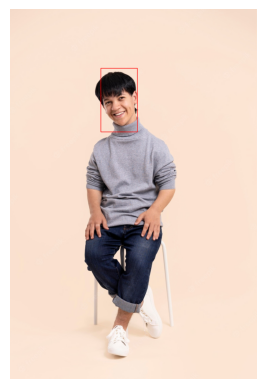

In [6]:
def plot_image(image_path, box):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 2)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Show first image
sample = df.iloc[0]
img_path = f"/kaggle/input/human-faces-object-detection/images/{sample['image_name']}"
bbox = [sample['x0'], sample['y0'], sample['x1'], sample['y1']]
plot_image(img_path, bbox)

In [7]:
IMG_SIZE = 128

def load_data(df):
    X, y = [], []
    for _, row in df.iterrows():
        path = f"/kaggle/input/human-faces-object-detection/images/{row['image_name']}"
        img = cv2.imread(path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X.append(img / 255.0)

        # Normalize bounding boxes
        x0 = row['x0'] / row['width']
        y0 = row['y0'] / row['height']
        x1 = row['x1'] / row['width']
        y1 = row['y1'] / row['height']
        y.append([x0, y0, x1, y1])
    
    return np.array(X), np.array(y)

X, y = load_data(df)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [8]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='sigmoid')  # bounding box [x0, y0, x1, y1]
])

model.compile(optimizer='adam', loss='mse')
model.summary()

2025-10-03 12:18:13.614169: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,764 (397.52 KB)

 Trainable params: 101,764 (397.52 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=16)

Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 39s 215ms/step - loss: 0.0323 - val_loss: 0.0298
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 36s 213ms/step - loss: 0.0276 - val_loss: 0.0289
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 36s 213ms/step - loss: 0.0266 - val_loss: 0.0288
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 36s 214ms/step - loss: 0.0260 - val_loss: 0.0286
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 36s 212ms/step - loss: 0.0256 - val_loss: 0.0287
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 35s 211ms/step - loss: 0.0274 - val_loss: 0.0285
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 35s 210ms/step - loss: 0.0265 - val_loss: 0.0282
Epoch 8/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 35s 210ms/step - loss: 0.0264 - val_loss: 0.0284
Epoch 9/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 36s 214ms/step - loss: 0.0263 - val_loss: 0.0278
Epoch 10/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 35s 209ms/step - loss: 0.0259 - val_loss: 0.0282


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


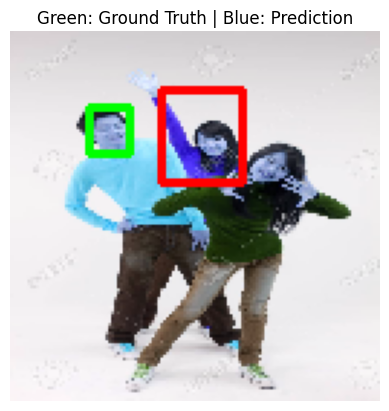

In [10]:
def unnormalize_bbox(bbox, width, height):
    x0 = int(bbox[0] * width)
    y0 = int(bbox[1] * height)
    x1 = int(bbox[2] * width)
    y1 = int(bbox[3] * height)
    return [x0, y0, x1, y1]

# Pick a validation image
i = 0
img = X_val[i]
true_box = unnormalize_bbox(y_val[i], IMG_SIZE, IMG_SIZE)
pred_box = unnormalize_bbox(model.predict(np.expand_dims(img, axis=0))[0], IMG_SIZE, IMG_SIZE)

# Draw both
img_draw = (img * 255).astype(np.uint8)
cv2.rectangle(img_draw, (true_box[0], true_box[1]), (true_box[2], true_box[3]), (0, 255, 0), 2)  # Green: True
cv2.rectangle(img_draw, (pred_box[0], pred_box[1]), (pred_box[2], pred_box[3]), (255, 0, 0), 2)  # Blue: Pred

plt.imshow(img_draw)
plt.axis('off')
plt.title('Green: Ground Truth | Blue: Prediction')
plt.show()